# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [62]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\lpoluri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


#### **1.2** Import necessary libraries

In [63]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [192]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

In [65]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [66]:
# define a function to load json file to a dataframe
def load_json_dataframe(path):
    return pd.read_json(path)

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [67]:
# read the json file by giving the file path and create a dataframe
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [68]:
# display first five rows of the dataframe - df
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [69]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [70]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [71]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
# Tokenize input
# input_tokens = [input.split() for input in df.input]
df['input_tokens'] = pd.DataFrame(df.input.str.split())
# Tokenize POS
# pos_tokens = [pos.split() for pos in df.pos]
df['pos_tokens'] = pd.DataFrame(df.pos.str.split())

In [72]:
# display first five rows of the dataframe - df
# print("first 5 rows of input_tokens\n", input_tokens[:5])
# print("\nFirst 5 rows of pos_tokens\n", pos_tokens[:5])
# print("first 5 rows of", input_tokens.shape[0], " input_tokens\n", input_tokens.head())
# print("\nFirst 5 rows of", pos_tokens.shape[0], " pos_tokens\n", pos_tokens.head())
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [74]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df.input_tokens.apply(len)
df['pos_length'] = df.pos_tokens.apply(len)
print(df.input_length.head())
print(df.pos_length.head())

0    31
1    34
2    37
3    46
4    21
Name: input_length, dtype: int64
0    31
1    34
2    37
3    46
4    21
Name: pos_length, dtype: int64


In [75]:
# check for the equality of input_length and pos_length in the dataframe
improperTokenizedIndices = df[df['input_length'] != df['pos_length']].index
print("indices which have invalid data based on input_length and pos_length are ", improperTokenizedIndices.tolist())
print(df.loc[improperTokenizedIndices.tolist()].input_length)
print(df.loc[improperTokenizedIndices.tolist()].pos_length)

indices which have invalid data based on input_length and pos_length are  [17, 27, 79, 164, 207]
17     15
27     37
79     38
164    54
207    18
Name: input_length, dtype: int64
17     14
27     36
79     37
164    53
207    17
Name: pos_length, dtype: int64


In [76]:
print(df.loc[17])

input                                                                        2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt
pos                            quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient
input_tokens                                                 [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]
pos_tokens      [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]
input_length                                                                                                                                                  15
pos_length                                                                                                                                                    14
Name: 17, dtype: object


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [77]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    print("unique lables used in the data are ", df.pos_tokens.explode().unique())
unique_labels(df)

unique lables used in the data are  ['quantity' 'ingredient' 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[17, 27, 79, 164, 207]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [79]:
# drop the irrelevant recipe data
new_df = df.drop(improperTokenizedIndices.tolist())

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [81]:
# update the input and pos length in input_length and pos_length
print("updated length of input_tokens is : ", new_df.shape)
# print("updated length of pos_tokens is : ", pos_tokens.shape)

updated length of input_tokens is :  (280, 6)


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [82]:
# validate the input length and pos length as input_length and pos_length
new_df[new_df['input_length'] != new_df['pos_length']].index

Index([], dtype='int64')

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [86]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(new_df, train_size=0.7, random_state=100)
print("train_df size: ", train_df.shape)
print("\n val_df size: ", val_df.shape)

train_df size:  (196, 6)

 val_df size:  (84, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [87]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
148,2 cups Rice 4 tablespoons Sunflower Oil 1 Onion chopped Tomato tablespoon Ginger Garlic Paste 1/4 teaspoon Red Chilli powder cup Carrots Gajjar Green peas Matar steamed Bell Pepper Capsicum Potato Aloo cut into small cubes Cardamom Elaichi Pods Seeds Cloves Laung Garam masala Star anise inch Cinnamon Stick Dalchini Coriander Dhania Leaves a bunch finely Mint Pudina few sprigs Salt,quantity unit ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[2, cups, Rice, 4, tablespoons, Sunflower, Oil, 1, Onion, chopped, Tomato, tablespoon, Ginger, Garlic, Paste, 1/4, teaspoon, Red, Chilli, powder, cup, Carrots, Gajjar, Green, peas, Matar, steamed, Bell, Pepper, Capsicum, Potato, Aloo, cut, into, small, cubes, Cardamom, Elaichi, Pods, Seeds, Cloves, Laung, Garam, masala, Star, anise, inch, Cinnamon, Stick, Dalchini, Coriander, Dhania, Leaves, a, bunch, finely, Mint, Pudina, few, sprigs, Salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",61,61
160,400 grams Tindora Dondakaya Kovakkai 1 teaspoon Mustard seeds 1/2 White Urad Dal pinch Asafoetida hing sprig Curry leaves Dry Red Chilli tablespoon Sunflower Oil 2 tablespoons Coriander Dhania Seeds Chana dal Bengal Gram 4 Chillies 1/4,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity,"[400, grams, Tindora, Dondakaya, Kovakkai, 1, teaspoon, Mustard, seeds, 1/2, White, Urad, Dal, pinch, Asafoetida, hing, sprig, Curry, leaves, Dry, Red, Chilli, tablespoon, Sunflower, Oil, 2, tablespoons, Coriander, Dhania, Seeds, Chana, dal, Bengal, Gram, 4, Chillies, 1/4]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity]",37,37
147,350 grams Paneer diced in cubes 1 pinch Asafoetida hing 2 inch Cinnamon Stick Dalchini Bay leaves tej patta 6 Cardamom Pods/Seeds 1/2 teaspoon Ajwain Carom seeds 3 Homemade tomato puree Kashmiri Red Chilli Powder Dry ginger powder 1/4 cup Curd Dahi Yogurt Fennel Saunf powdered Saffron strands Garam masala Salt sprig Coriander Dhania Leaves garnish,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient ingredient ingredient in

In [88]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
177,2 cups rice cooked tomatoes finely chopped 1 onion thinly sliced teaspoon red chilli powder green slit mint leaves pudina fistful coriander dhania small bunch cinnamon stick dalchini cloves laung sprig curry tablespoon ghee salt inch ginger roughly 3 to 4 garlic fennel seeds saunf,quantity unit ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient ingredient,"[2, cups, rice, cooked, tomatoes, finely, chopped, 1, onion, thinly, sliced, teaspoon, red, chilli, powder, green, slit, mint, leaves, pudina, fistful, coriander, dhania, small, bunch, cinnamon, stick, dalchini, cloves, laung, sprig, curry, tablespoon, ghee, salt, inch, ginger, roughly, 3, to, 4, garlic, fennel, seeds, saunf]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, ingredient]",45,45
249,12 Baby Potatoes 1 Dry Red Chilli teaspoon Cumin seeds sprig Curry leaves Coriander Powder 1/2 Turmeric powder Garam masala Amchur Mango Lemon juice 3 tablespoons Leaves chopped,quantity ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient,"[12, Baby, Potatoes, 1, Dry, Red, Chilli, teaspoon, Cumin, seeds, sprig, Curry, leaves, Coriander, Powder, 1/2, Turmeric, powder, Garam, masala, Amchur, Mango, Lemon, juice, 3, tablespoons, Leaves, chopped]","[quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]",28,28
202,200 grams Jackfruit Raw Kathal 1 Onion sliced 4 cloves Garlic chopped inch Ginger tablespoon Cumin powder Jeera teaspoon Black pepper 1/2 Cinnamon Powder Dalchini 2 Paprika Turmeric Haldi cup Rajma Large Kidney Beans soaked boiled Tomato Red Chilli Sugar 1/4 Cooked rice Dried Thyme Leaves Bell Capsicum Yellow Pepper Green Sour cream Salsa Tortillas,quantity unit ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient unit ingredient unit ingredient ingredient ingredient unit ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[200, grams, Jackfruit, Raw, Kathal, 1, Onion, sliced, 4, cloves, Garlic, chopped, inch, Ginger, tablespoon, Cumin, powder, Jeera, teaspoon, Black, pepper, 1/2, Cinnamon, Powder, Dalchini, 2, Paprika, Turmeric, Haldi, cup, Rajma, Large, Kidney, Beans, soaked, boiled, Tomato, Red, Chilli, Sugar, 1/4, Cooked, rice, Dried, Thyme, Leaves, Bell, Capsicum, Yellow, Pepper, Green, Sour, cream, Salsa, Tortillas]","[quantity, unit, in

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [89]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df.input_tokens.tolist()
y_train = train_df.pos_tokens.tolist()

X_val = val_df.input_tokens.tolist()
y_val = val_df.pos_tokens.tolist()

In [91]:
# validate the shape of training and validation samples
print("len(X_train): ", len(X_train))
print("len(y_train): ", len(y_train))
print("len(X_val): ", len(X_val))
print("len(y_val): ", len(y_val))

len(X_train):  196
len(y_train):  196
len(X_val):  84
len(y_val):  84


In [93]:
print(X_train)
print(y_train)

[['2', 'cups', 'Rice', '4', 'tablespoons', 'Sunflower', 'Oil', '1', 'Onion', 'chopped', 'Tomato', 'tablespoon', 'Ginger', 'Garlic', 'Paste', '1/4', 'teaspoon', 'Red', 'Chilli', 'powder', 'cup', 'Carrots', 'Gajjar', 'Green', 'peas', 'Matar', 'steamed', 'Bell', 'Pepper', 'Capsicum', 'Potato', 'Aloo', 'cut', 'into', 'small', 'cubes', 'Cardamom', 'Elaichi', 'Pods', 'Seeds', 'Cloves', 'Laung', 'Garam', 'masala', 'Star', 'anise', 'inch', 'Cinnamon', 'Stick', 'Dalchini', 'Coriander', 'Dhania', 'Leaves', 'a', 'bunch', 'finely', 'Mint', 'Pudina', 'few', 'sprigs', 'Salt'], ['400', 'grams', 'Tindora', 'Dondakaya', 'Kovakkai', '1', 'teaspoon', 'Mustard', 'seeds', '1/2', 'White', 'Urad', 'Dal', 'pinch', 'Asafoetida', 'hing', 'sprig', 'Curry', 'leaves', 'Dry', 'Red', 'Chilli', 'tablespoon', 'Sunflower', 'Oil', '2', 'tablespoons', 'Coriander', 'Dhania', 'Seeds', 'Chana', 'dal', 'Bengal', 'Gram', '4', 'Chillies', '1/4'], ['350', 'grams', 'Paneer', 'diced', 'in', 'cubes', '1', 'pinch', 'Asafoetida', 'h

###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [99]:
# Display the number of unique labels present in y_train
labels = [label for list in y_train for label in list]
uniqueLabels = np.unique(labels)
print("unique labels are: ", uniqueLabels)
print("no of unique labels: ", len(uniqueLabels))


unique labels are:  ['ingredient' 'quantity' 'unit']
no of unique labels:  3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [102]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nestedList):
    return [label for list in nestedList for label in list]

input_tokens_flat = flatten_list(X_train)
pos_tokens_flat = flatten_list(y_train)

print("length of input tokens list: ", len(input_tokens_flat))
print("length of pos tokens list: ", len(pos_tokens_flat))

length of input tokens list:  6772
length of pos tokens list:  6772


In [103]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [105]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    # Flatten the input_tokens and pos_tokens using the flatten_list function
    input_tokens_flat = flatten_list(df['input_tokens'])
    pos_tokens_flat = flatten_list(df['pos_tokens'])

    # Validate the lengths of the flattened tokens
    print(f"{dataset_name} - Length of input_tokens:", len(input_tokens_flat))
    print(f"{dataset_name} - Length of pos_tokens:", len(pos_tokens_flat))

    # Display first 10 records of input_tokens and pos_tokens
    print(f"\n{dataset_name} - First 10 input_tokens:", input_tokens_flat[:10])
    print(f"{dataset_name} - First 10 pos_tokens:", pos_tokens_flat[:10])

In [107]:
# extract the tokens and its pos tags
extract_and_validate_tokens(train_df, "Training")
extract_and_validate_tokens(val_df, "Validation")

Training - Length of input_tokens: 6772
Training - Length of pos_tokens: 6772

Training - First 10 input_tokens: ['2', 'cups', 'Rice', '4', 'tablespoons', 'Sunflower', 'Oil', '1', 'Onion', 'chopped']
Training - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient']
Validation - Length of input_tokens: 3218
Validation - Length of pos_tokens: 3218

Validation - First 10 input_tokens: ['2', 'cups', 'rice', 'cooked', 'tomatoes', 'finely', 'chopped', '1', 'onion', 'thinly']
Validation - First 10 pos_tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [110]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(nestedTokens, nestedPosTags):
    tokens_flat = flatten_list(nestedTokens)
    pos_flat = flatten_list(nestedPosTags)
    ingredients = []
    units = []
    quantities = []

    for token, pos in zip(tokens_flat, pos_flat):
        if pos == 'ingredient':
            ingredients.append(token)
        elif pos == 'unit':
            units.append(token)
        elif pos == 'quantity':
            quantities.append(token)
    return ingredients, units, quantities

In [114]:
#  call the function to categorise the labels into respective list
train_ingredients, train_units, train_quantities = categorize_tokens(train_df['input_tokens'], train_df['pos_tokens'])
val_ingredients, val_units, val_quantities = categorize_tokens(val_df['input_tokens'], val_df['pos_tokens'])

print("\nTraining - Ingredients:", train_ingredients[:10])
print("Training - Units:", train_units[:10])
print("Training - Quantities:", train_quantities[:10])

print("\nValidation - Ingredients:", val_ingredients[:10])
print("Validation - Units:", val_units[:10])
print("Validation - Quantities:", val_quantities[:10])


Training - Ingredients: ['Rice', 'Sunflower', 'Oil', 'Onion', 'chopped', 'Tomato', 'Ginger', 'Garlic', 'Paste', 'Red']
Training - Units: ['cups', 'tablespoons', 'tablespoon', 'teaspoon', 'cup', 'inch', 'grams', 'teaspoon', 'sprig', 'tablespoon']
Training - Quantities: ['2', '4', '1', '1/4', 'a', '400', '1', '1/2', 'pinch', '2']

Validation - Ingredients: ['rice', 'cooked', 'tomatoes', 'finely', 'chopped', 'onion', 'thinly', 'sliced', 'red', 'chilli']
Validation - Units: ['cups', 'teaspoon', 'tablespoon', 'teaspoon', 'sprig', 'tablespoons', 'grams', 'cloves', 'inch', 'tablespoon']
Validation - Quantities: ['2', '1', '3', '4', '12', '1', '1/2', '3', '200', '1']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [ ]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    """
    This function takes a list of items (e.g., ingredients or units), the label name (ingredient/unit), and the dataset name (Training/Validation).
    It returns the top 10 most frequent items from the list.
    """
    item_counter = Counter(item_list)  # Count the frequency of each item
    most_common_items = item_counter.most_common(10)  # Get the top 10 most frequent items
    print(f"Top 10 {pos_label}s in the {dataset_name} dataset:")
    return most_common_items

In [132]:
# get the top ingredients which are frequently seen in the recipe
top_ingrediants_train = get_top_frequent_items(train_ingredients, "ingredient", "Training")
top_ingrediants_train

Top 10 ingredients in the Training dataset:


[('powder', 125),
 ('Salt', 105),
 ('Oil', 84),
 ('seeds', 84),
 ('Red', 83),
 ('Chilli', 81),
 ('Green', 80),
 ('chopped', 71),
 ('Coriander', 65),
 ('Leaves', 61)]

In [133]:
top_ingrediants_val = get_top_frequent_items(val_ingredients, "ingredient", "Validation")
top_ingrediants_val

Top 10 ingredients in the Validation dataset:


[('powder', 58),
 ('chopped', 44),
 ('Salt', 44),
 ('seeds', 41),
 ('Oil', 38),
 ('Red', 37),
 ('Green', 35),
 ('Powder', 34),
 ('Coriander', 33),
 ('Leaves', 33)]

In [134]:
# get the top units which are frequently seen in the recipe
top_units_train = get_top_frequent_items(train_units, "unit", "Training")
top_units_train

Top 10 units in the Training dataset:


[('teaspoon', 153),
 ('cup', 131),
 ('tablespoon', 87),
 ('tablespoons', 69),
 ('grams', 56),
 ('cups', 55),
 ('inch', 48),
 ('sprig', 41),
 ('cloves', 39),
 ('teaspoons', 39)]

In [135]:
top_units_val = get_top_frequent_items(val_units, "unit", "Validation")
top_units_val

Top 10 units in the Validation dataset:


[('teaspoon', 68),
 ('cup', 62),
 ('tablespoon', 44),
 ('grams', 26),
 ('tablespoons', 24),
 ('inch', 24),
 ('sprig', 21),
 ('cups', 19),
 ('teaspoons', 18),
 ('cloves', 16)]

#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [146]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(item_list, label, dataset_name):
    """
    Plot a bar chart of top items using seaborn.
    
    Parameters:
    - top_items: List of tuples (e.g., [('apple', 10), ('banana', 5)])
    - label: String for x-axis label (e.g., 'ingredient' or 'unit')
    - dataset_name: String for plot title (e.g., 'Training' or 'Validation')
    """
    items, counts = zip(*item_list)
    sns.barplot(x=items, y=counts, palette='viridis')
    plt.title(f"Top 10 {label.title()}s in {dataset_name} Set")
    plt.xlabel(label.title())
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

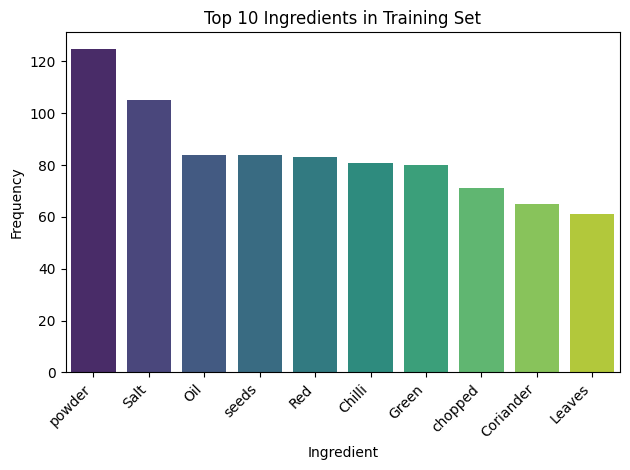

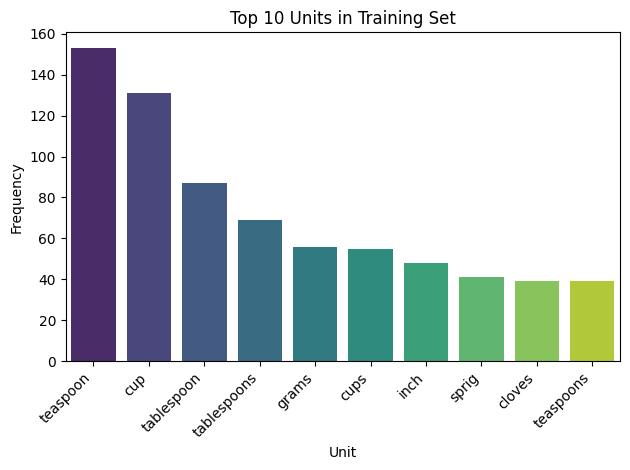

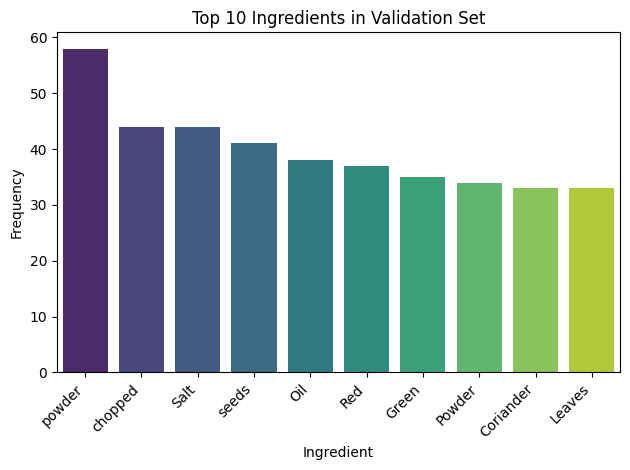

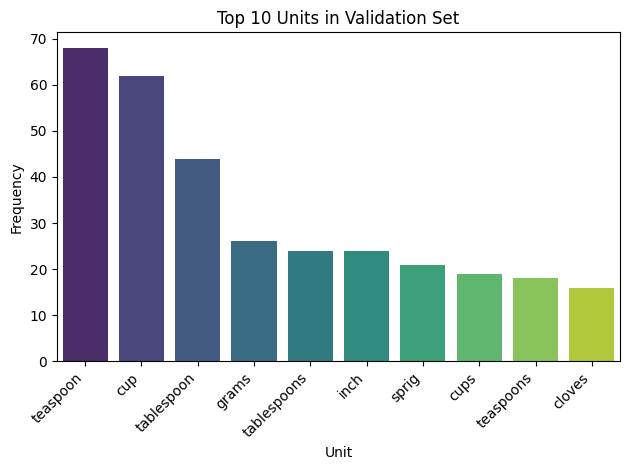

In [147]:
# Training
plot_top_items(top_ingrediants_train,  'ingredient', 'Training')
plot_top_items(top_units_train, 'unit',       'Training')

# Validation
plot_top_items(top_ingrediants_val,    'ingredient', 'Validation')
plot_top_items(top_units_val,   'unit',       'Validation')

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



In [149]:
top_ingrediants_train

[('powder', 125),
 ('Salt', 105),
 ('Oil', 84),
 ('seeds', 84),
 ('Red', 83),
 ('Chilli', 81),
 ('Green', 80),
 ('chopped', 71),
 ('Coriander', 65),
 ('Leaves', 61)]

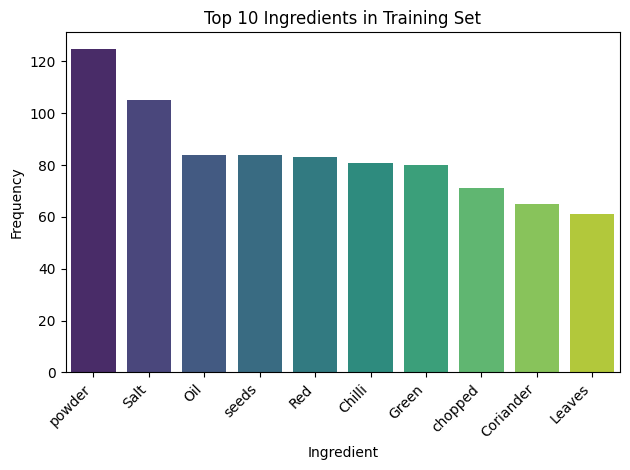

In [148]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingrediants_train,  'ingredient', 'Training')

**Insights**

1. "powder" & "Salt" dominate ingredient tokens

- "powder" (125) is highest—reflecting repeated mentions in spice names (e.g. "Turmeric powder").
- "Salt" (105) ranks second, underscoring its universal use.
2. Preparation descriptors are frequent

- "chopped" (71) and "Green" (80) appear as often as many core ingredients, indicating your NER must handle both food items and prep cues.
3. Whole‐spice mentions

- "seeds" (84) highlights the frequent use of items like "Cumin seeds" and "Mustard seeds".

[('teaspoon', 153), ('cup', 131), ('tablespoon', 87), ('tablespoons', 69), ('grams', 56), ('cups', 55), ('inch', 48), ('sprig', 41), ('cloves', 39), ('teaspoons', 39)]


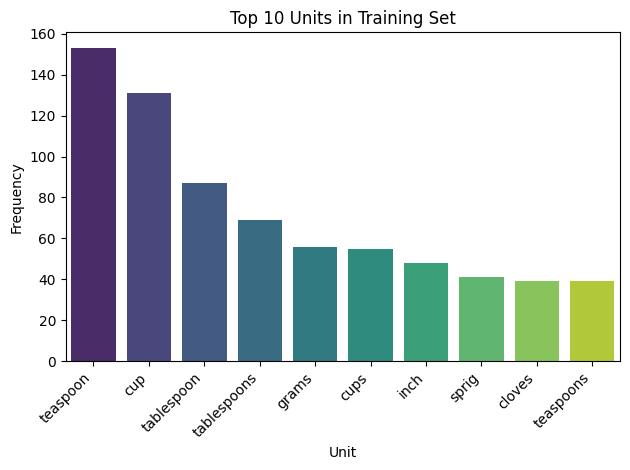

In [150]:
# plot the top frequent units in training data
print(top_units_train)
plot_top_items(top_units_train, 'unit','Training')

** Insights **

1. Units skewed to small measures

- "teaspoon" (153) and "cup" (131) together make up almost half of all unit mentions.
- "tablespoon" (87) is a distant third, while larger measures ("inch", "sprig") are much rarer.
2. Plural and Singular forms of tokens
- teaspoon and teaspoons are taken as 2 different tokens
- similarly tablespoon and tablespoons are treated as different tokens
- these forms should be handled through lemmatization which we will do it later.

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [ ]:
# initialise the dataset_name
dataset_name = "validation"

In [ ]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
# already done at the top

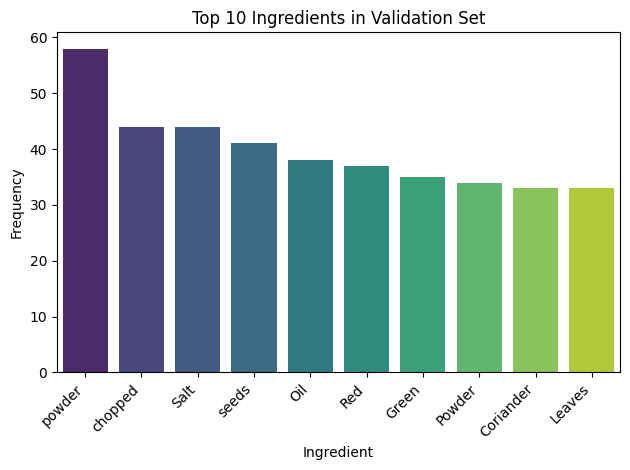

In [151]:
# plot the top frequent ingredients in validation data
plot_top_items(top_ingrediants_val, 'ingredient', 'Validation')

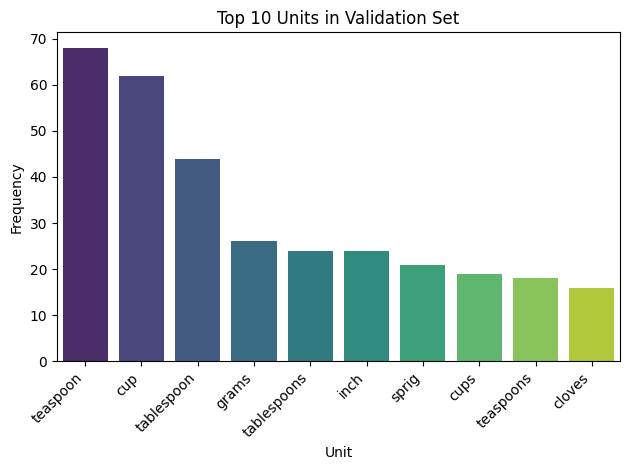

In [152]:
# plot the top frequent units in training data

plot_top_items(top_units_val, 'unit', 'Validation')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [ ]:
train_quantities

['2',
 '4',
 '1',
 '1/4',
 'a',
 '400',
 '1',
 '1/2',
 'pinch',
 '2',
 '4',
 '1/4',
 '350',
 '1',
 '2',
 '6',
 '1/2',
 '3',
 '1/4',
 '2',
 '1',
 '1/2',
 '100',
 '2',
 '1',
 '3',
 '400',
 '200',
 '4',
 '3',
 '1/4',
 '1/4',
 '500',
 '2',
 '1/8',
 'few',
 '1',
 'two',
 '1',
 '12',
 '1/4',
 '7',
 '4',
 '1/2',
 '2',
 '1/3',
 '3',
 '1',
 '10',
 '200',
 '2',
 '1',
 '1/2',
 '3',
 '1',
 '2',
 '1/2',
 '200',
 '2',
 '1',
 '1/2',
 '5',
 '3',
 '1/2',
 '2',
 '1',
 '4',
 '2',
 '1/2',
 '1',
 'a',
 '2',
 '5',
 '1',
 '1/2',
 '4',
 '2',
 '1',
 '3',
 '1/2',
 '6',
 '12',
 '4',
 '1',
 '3',
 '3',
 '6',
 '1/2',
 '1',
 '15',
 '2',
 '250',
 '1/2',
 '1',
 '3',
 '1-1/2',
 '500',
 '1/4',
 '1',
 '2',
 '1/2',
 '250',
 '1',
 '500',
 '1/4',
 '1',
 '2',
 '2-1',
 '1/4',
 '1/2',
 '300',
 '200',
 '1',
 '4',
 '1/2',
 '3',
 '4',
 '3',
 '1',
 '1/2',
 '1',
 '2',
 '1',
 '2',
 '1/2',
 '1',
 '2',
 '4',
 '1/2',
 '10',
 '150',
 '1',
 '200',
 '50',
 '7-8',
 '2',
 '10',
 '12',
 '1',
 '1/2',
 '6',
 '3-4',
 '3',
 '6-8',
 'few',
 '1-1/

In [154]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {
    "cup", "cups", "tbsp", "tablespoon", "tablespoons",
    "tsp", "teaspoon", "teaspoons", "g", "gm", "gram", "grams", "gms",
    "kg", "ml", "l", "litre", "pinch", "sprig", "inch", "inches"
}

quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three",
    "four", "five", "six", "seven", "eight", "nine", "ten"
}

quantity_pattern = re.compile(r"""^(
    \d+             |   # integer
    \d+\.\d+        |   # decimal
    \d+/\d+         |   # simple fraction
    \d+-\d+/\d+         # mixed fraction e.g. 1-1/2
)$""", re.VERBOSE)

In [155]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [156]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---
def word2features(sent, i):
    """
    Extracts features for token sent[i] in the token list `sent`.
    Uses spaCy for lexical features and our keyword sets/regex for measurement flags.
    """
    token = sent[i]
    # run spaCy on the token itself to get lemma, pos, etc.
    doc = nlp(token)
    tok = doc[0]

    # Core lexical & grammatical features
    features = {
        "bias": 1.0,
        "token.lower": token.lower(),
        "lemma": tok.lemma_.lower(),
        "pos_tag": tok.pos_,
        "tag": tok.tag_,
        "dep": tok.dep_,
        "shape": tok.shape_,
        "is_stop": tok.is_stop,
        "is_digit": token.isdigit(),
        "has_digit": any(ch.isdigit() for ch in token),
        "has_alpha": any(ch.isalpha() for ch in token),
        "hyphenated": "-" in token,
        "slash_present": "/" in token,
        "is_title": token.istitle(),
        "is_upper": token.isupper(),
        "is_punct": tok.is_punct,
    }

    # Quantity & Unit detection features
    features.update({
        "is_quantity_kw": token.lower() in quantity_keywords,
        "matches_quantity_pattern": bool(quantity_pattern.match(token)),
        "is_quantity": token.lower() in quantity_keywords or bool(quantity_pattern.match(token)),
        "is_unit": token.lower() in unit_keywords,
        "is_fraction": "/" in token,
        "is_decimal": bool(re.match(r"^\d+\.\d+$", token)),
        "is_numeric": token.replace("-", "").replace("/", "").replace(".", "").isdigit(),
    })

    # Contextual features
    if i == 0:
        features["BOS"] = True
    else:
        prev = sent[i - 1]
        features.update({
            "prev_token": prev.lower(),
            "prev_is_quantity": prev.lower() in quantity_keywords or bool(quantity_pattern.match(prev)),
            "prev_is_digit": prev.isdigit(),
        })

    if i == len(sent) - 1:
        features["EOS"] = True
    else:
        nxt = sent[i + 1]
        features.update({
            "next_token": nxt.lower(),
            "next_is_unit": nxt.lower() in unit_keywords,
            "next_is_ingredient": (nxt.lower() not in unit_keywords and nxt.lower() not in quantity_keywords),
        })

    return features

In [157]:
# eg
sent = X_train[0]  
feat_dict = word2features(sent, 2)
print(feat_dict)

{'bias': 1.0, 'token.lower': 'rice', 'lemma': 'rice', 'pos_tag': 'NOUN', 'tag': 'NN', 'dep': 'ROOT', 'shape': 'Xxxx', 'is_stop': False, 'is_digit': False, 'has_digit': False, 'has_alpha': True, 'hyphenated': False, 'slash_present': False, 'is_title': True, 'is_upper': False, 'is_punct': False, 'is_quantity_kw': False, 'matches_quantity_pattern': False, 'is_quantity': False, 'is_unit': False, 'is_fraction': False, 'is_decimal': False, 'is_numeric': False, 'prev_token': 'cups', 'prev_is_quantity': False, 'prev_is_digit': False, 'next_token': '4', 'next_is_unit': False, 'next_is_ingredient': True}


### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [161]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(labels):
    return labels

def sent2tokens(sent):
    return sent  

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [162]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(s) for s in X_train]

X_val_features = [sent2features(s) for s in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [163]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [sent2labels(l) for l in y_train]
y_val_labels = [sent2labels(l) for l in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [165]:
# print the length of train features and labels
print(len(X_train_features), len(y_train_labels))

196 196


In [167]:
# print the length of validation features and labels
print(len(X_val_features),   len(y_val_labels))

84 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [170]:
# Flatten labels in y_train
# y_train_labels
y_train_flat = [label for seq in y_train_labels for label in seq]

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [171]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
# Verify by checking length vs. sum of individual sequence lengths
print(f"Length of flattened y_train labels: {len(y_train_flat)}")
print(f"Sum of lengths of each y_train sequence: {sum(len(seq) for seq in y_train_labels)}")

# Count the frequencies of each label in y_train_flat
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())

# Display label counts and total samples
print("Label Counts:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")

print(f"\nTotal samples (tokens) in y_train_flat: {total_samples}")


Length of flattened y_train labels: 6772
Sum of lengths of each y_train sequence: 6772
Label Counts:
  quantity: 959
  unit: 813
  ingredient: 5000

Total samples (tokens) in y_train_flat: 6772


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [172]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Compute class weights using inverse frequency
weight_dict = {}

for label, count in label_counts.items():
    # Inverse frequency
    weight_dict[label] = total_samples / (count if count else 1)

In [173]:
# penalise ingredient label
weight_dict['ingredient'] *= 1.5

In [174]:
print("Computed class weights:")
for label, weight in weight_dict.items():
    print(f"  {label}: {weight:.4f}")

Computed class weights:
  quantity: 7.0615
  unit: 8.3296
  ingredient: 2.0316


- "unit" and "quantity" have the highest weights, indicating they are the least frequent labels in your training data. The model will pay more attention to features associated with these labels during training.
- "ingredient" has the lowest weight, suggesting it's the most frequent label. The model needs less emphasis on learning "ingredient" because it has many examples.
- dditional Penalization of "ingredient",here the code further penalizes the "ingredient" label by multiplying its weight by 1.5. This is done to intentionally make the "ingredient" even less important to the model.
- This is necessary if the "ingredient" occurs too frequently and tends to overshadow the "unit" and "quantity" labels during training.

##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [175]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extracts features and applies class weights.
    """
    X_feats = [sent2features(s) for s in X]
    y_labels = [sent2labels(l) for l in y]

    # Apply weights to labels in the training data
    weighted_y_train = []
    for sequence in y_labels:
        weighted_sequence = []
        for label in sequence:
            weighted_sequence.append(weight_dict.get(label, 1.0))  # Default weight is 1.0
        weighted_y_train.append(weighted_sequence)

    return X_feats, y_labels, weighted_y_train

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [176]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels, y_train_weights = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_weighted_labels, y_val_weights = extract_features_with_class_weights(X_val, y_val, weight_dict)

In [183]:
X_train_weighted_features[0]

[{'bias': 1.0,
  'token.lower': '2',
  'lemma': '2',
  'pos_tag': 'NUM',
  'tag': 'CD',
  'dep': 'ROOT',
  'shape': 'd',
  'is_stop': False,
  'is_digit': True,
  'has_digit': True,
  'has_alpha': False,
  'hyphenated': False,
  'slash_present': False,
  'is_title': False,
  'is_upper': False,
  'is_punct': False,
  'is_quantity_kw': False,
  'matches_quantity_pattern': True,
  'is_quantity': True,
  'is_unit': False,
  'is_fraction': False,
  'is_decimal': False,
  'is_numeric': True,
  'BOS': True,
  'next_token': 'cups',
  'next_is_unit': True,
  'next_is_ingredient': False},
 {'bias': 1.0,
  'token.lower': 'cups',
  'lemma': 'cup',
  'pos_tag': 'NOUN',
  'tag': 'NNS',
  'dep': 'ROOT',
  'shape': 'xxxx',
  'is_stop': False,
  'is_digit': False,
  'has_digit': False,
  'has_alpha': True,
  'hyphenated': False,
  'slash_present': False,
  'is_title': False,
  'is_upper': False,
  'is_punct': False,
  'is_quantity_kw': False,
  'matches_quantity_pattern': False,
  'is_quantity': False,

In [182]:
y_train_weights

[[7.061522419186653,
  8.329643296432964,
  2.0316,
  7.061522419186653,
  8.329643296432964,
  2.0316,
  2.0316,
  7.061522419186653,
  2.0316,
  2.0316,
  2.0316,
  8.329643296432964,
  2.0316,
  2.0316,
  2.0316,
  7.061522419186653,
  8.329643296432964,
  2.0316,
  2.0316,
  2.0316,
  8.329643296432964,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  8.329643296432964,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  7.061522419186653,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316,
  2.0316],
 [7.061522419186653,
  8.329643296432964,
  2.0316,
  2.0316,
  2.0316,
  7.061522419186653,
  8.329643296432964,
  2.0316,
  2.0316,
  7.061522419186653,
  2.0316,
  2.0316,
  2.0316,
  7.061522419186653,
  2.0316,
  2.0316,
  8.329643296432964,
  2.0316,
  2.0316,
 

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [185]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
# train the CRF model with the weighted training data
crf.fit(
    X=X_train_weighted_features,
    y=y_train_weighted_labels
)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=0.1,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [188]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)
metrics.flat_f1_score(y_train_weighted_labels, y_train_pred, average='weighted')

0.9902077273607413

In [189]:
# specify the flat classification report by using training data for evaluation
report = metrics.flat_classification_report(
    y_pred=y_train_pred,
    y_true=y_train_labels,
    digits=3
)

print(report)

              precision    recall  f1-score   support

  ingredient      0.990     0.997     0.994      5000
    quantity      0.996     0.985     0.991       959
        unit      0.984     0.954     0.969       813

    accuracy                          0.990      6772
   macro avg      0.990     0.979     0.984      6772
weighted avg      0.990     0.990     0.990      6772



### 1. ingredient (most frequent class):
   - Very high recall (0.997): Model captures nearly all true ingredient tokens.
   - Precision (0.990): Few false positives.
   - F1-score (0.994): Excellent overall — the model is extremely confident and accurate for this class.

### 2. quantity:
   - Precision (0.996) > Recall (0.985): Model is slightly more conservative, making fewer mistakes when it does predict a quantity — but misses a few.
   - F1-score (0.991): Still very strong.

### 3. unit (least frequent class):
   - Recall is lowest (0.954): Some actual unit tokens are missed.
   - F1-score (0.969): Lower than other classes but still strong, especially considering its relatively small support (813).

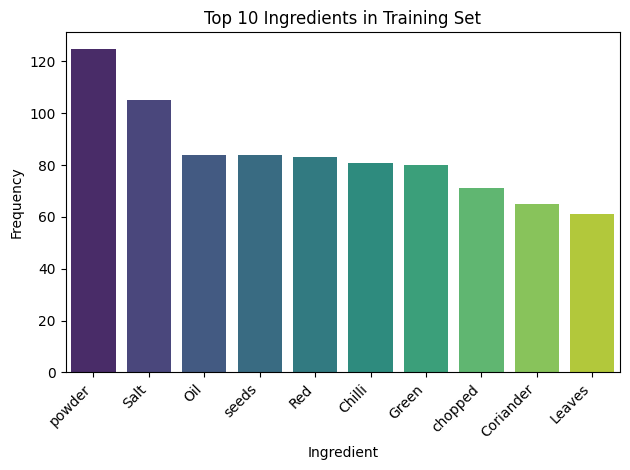

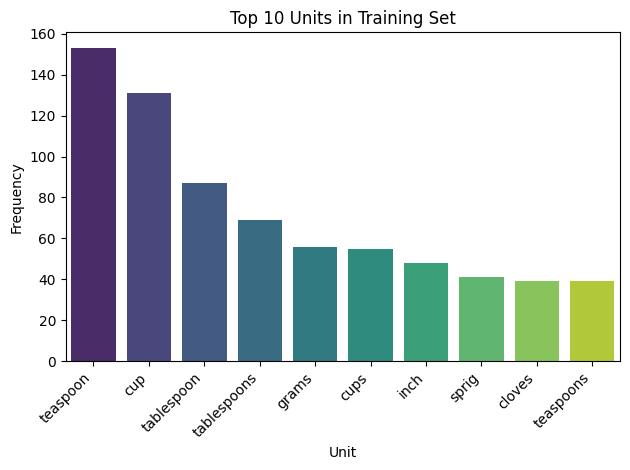

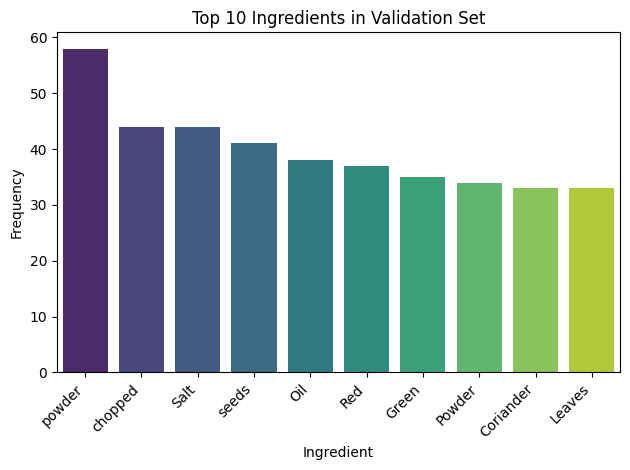

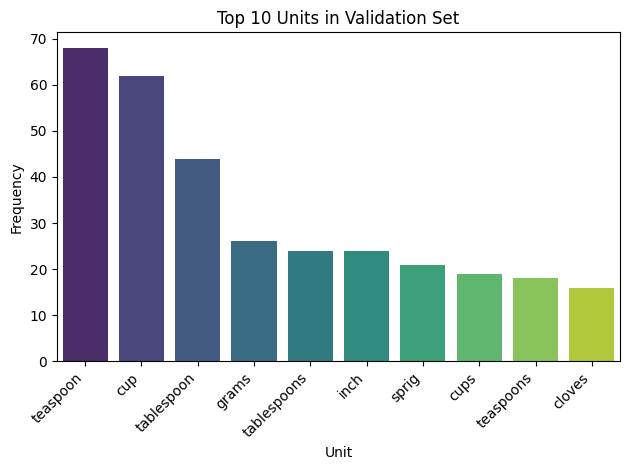

In [ ]:
# Training
plot_top_items(top_ingrediants_train,  'ingredient', 'Training')
plot_top_items(top_units_train, 'unit',       'Training')

# Validation
plot_top_items(top_ingrediants_val,    'ingredient', 'Validation')
plot_top_items(top_units_val,   'unit',       'Validation')

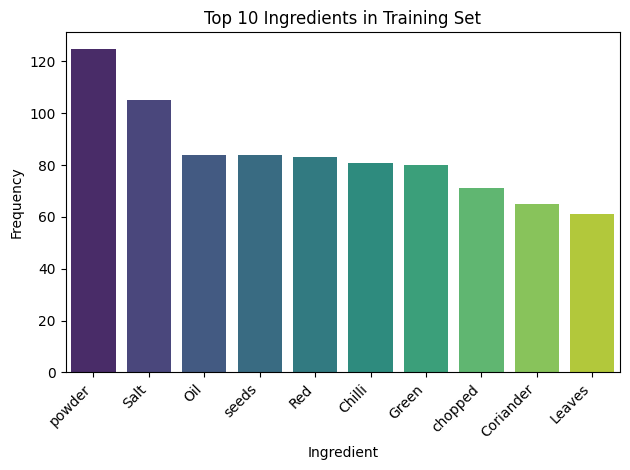

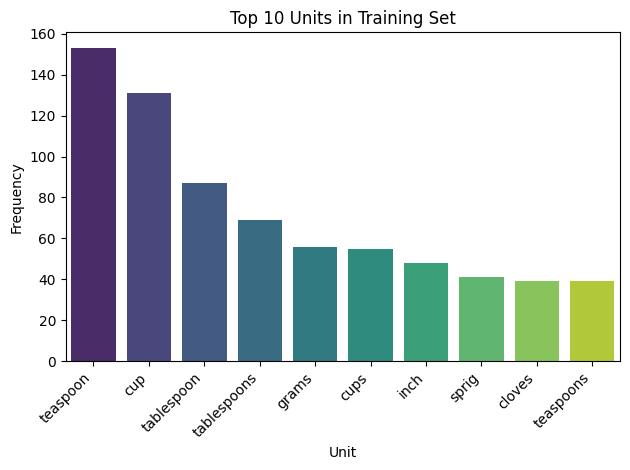

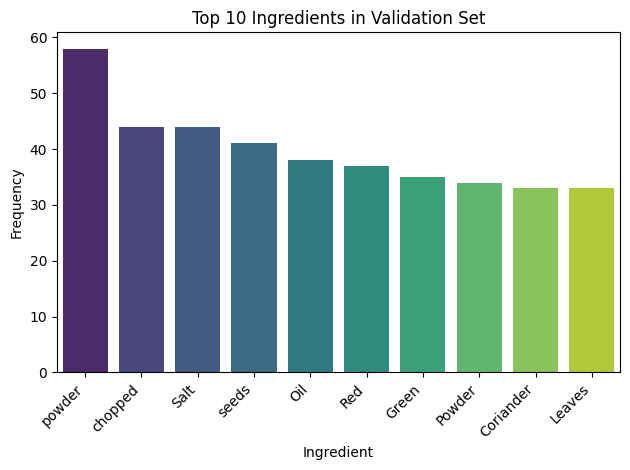

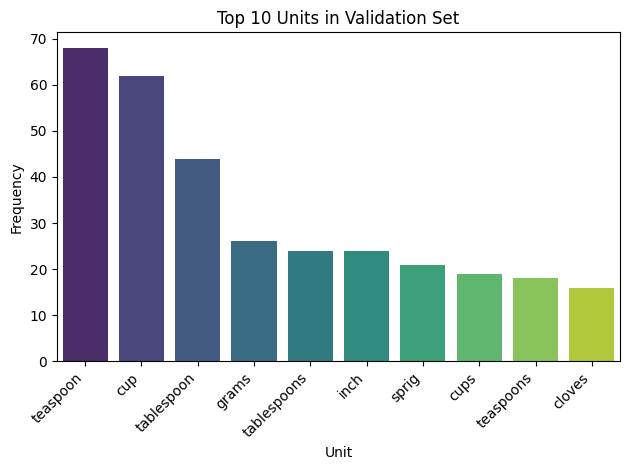

In [ ]:
# Training
plot_top_items(top_ingrediants_train,  'ingredient', 'Training')
plot_top_items(top_units_train, 'unit',       'Training')

# Validation
plot_top_items(top_ingrediants_val,    'ingredient', 'Validation')
plot_top_items(top_units_val,   'unit',       'Validation')

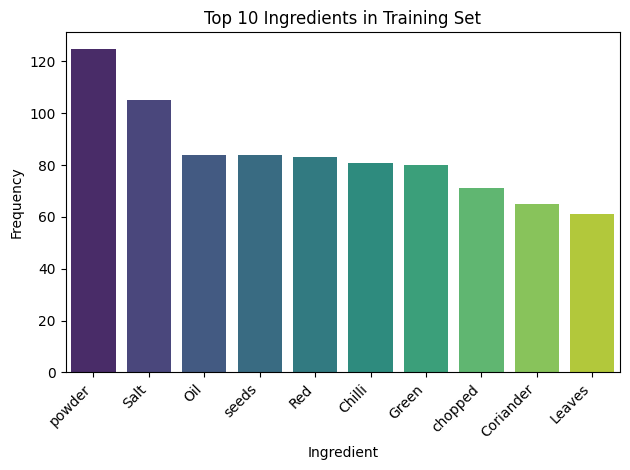

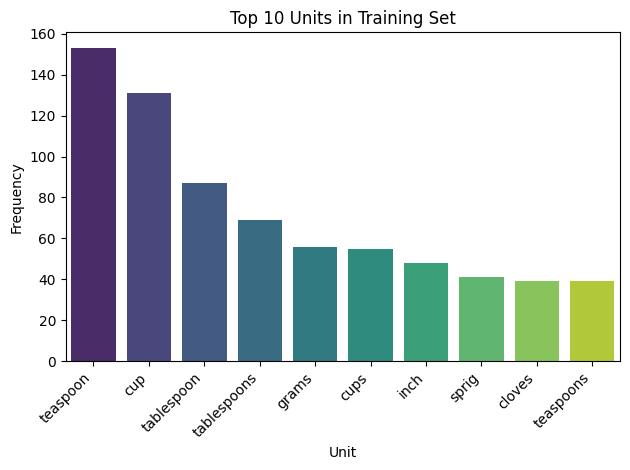

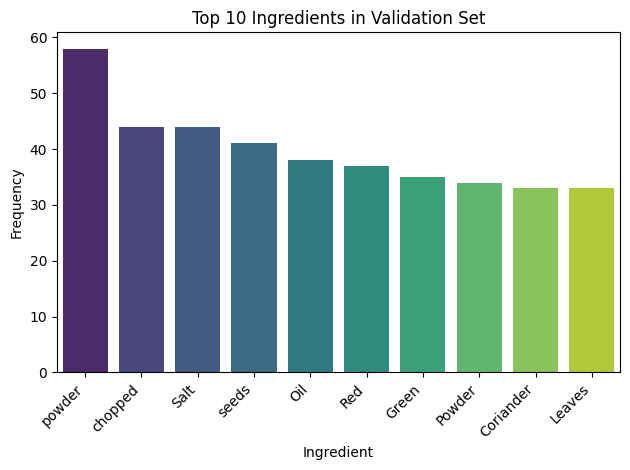

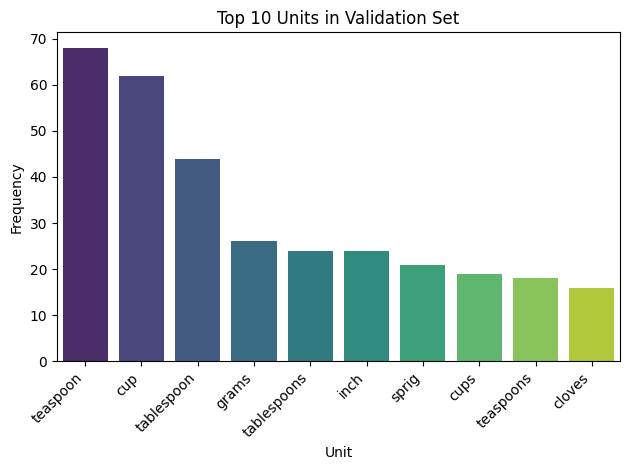

In [ ]:
# Training
plot_top_items(top_ingrediants_train,  'ingredient', 'Training')
plot_top_items(top_units_train, 'unit',       'Training')

# Validation
plot_top_items(top_ingrediants_val,    'ingredient', 'Validation')
plot_top_items(top_units_val,   'unit',       'Validation')

**Interpretation**
- CRF model is highly effective, especially on more frequent classes like ingredient.

- Slight performance drops on the unit class are expected due to lower representation.

- These results suggest the model is well-fit to the training data — possibly even slightly overfitting, as these are training scores.

In [197]:
# create a confusion matrix on training datset
cm = confusion_matrix(flatten_list(y_train_pred), flatten_list(y_train_labels))
labels = sorted(set(flatten_list(y_train_labels)))
labels

['ingredient', 'quantity', 'unit']

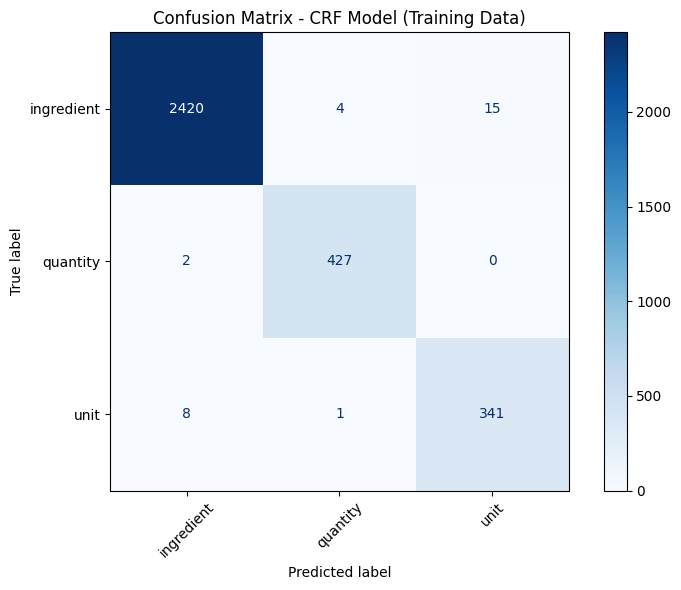

In [280]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CRF Model (Training Data)")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [199]:
# dump the model using joblib as crf_model.pkl
import pickle

with open("crf_model.pkl", "wb") as f:
    pickle.dump(crf, f)

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [200]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [201]:
# specify flat classification report
report = metrics.flat_classification_report(
    y_pred=y_val_pred,
    y_true=y_val_labels,
    digits=3
)

print(report)

              precision    recall  f1-score   support

  ingredient      0.992     0.996     0.994      2430
    quantity      0.995     0.988     0.992       432
        unit      0.974     0.958     0.966       356

    accuracy                          0.991      3218
   macro avg      0.987     0.981     0.984      3218
weighted avg      0.991     0.991     0.991      3218



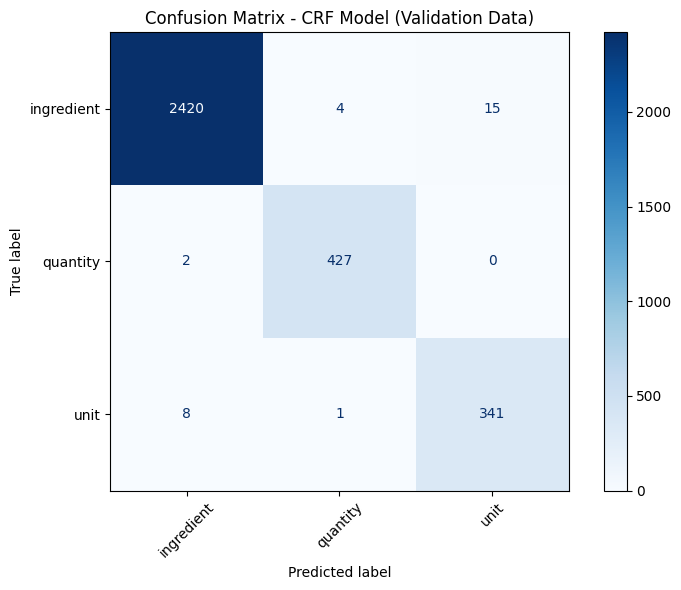

In [203]:
# create a confusion matrix on validation dataset
cm = confusion_matrix(flatten_list(y_val_pred), flatten_list(y_val_labels))
labels = sorted(set(flatten_list(y_val_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - CRF Model (Validation Data)")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [210]:
# flatten Labels and Initialise Error Data
y_val_labels_flat = flatten_list(y_val_labels)
error_data = []
len(y_val_labels_flat)

3218

In [209]:
y_val_pred_flat = flatten_list(y_val_pred)
len(y_val_pred_flat)

3218

In [212]:
X_val_features_flat = flatten_list(X_val_weighted_features)

In [213]:
len(X_val_features_flat)

3218

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [237]:
for i, (trueval, predval) in enumerate(zip(flatten_list(y_val_labels),flatten_list(y_val_pred))):
    if(trueval != predval):
        print(trueval, predval)

ingredient unit
ingredient unit
quantity ingredient
quantity ingredient
unit ingredient
unit ingredient
unit ingredient
unit ingredient
unit ingredient
unit ingredient
unit ingredient
quantity ingredient
ingredient unit
ingredient unit
ingredient quantity
unit ingredient
unit ingredient
unit ingredient
unit ingredient
unit ingredient
quantity unit
ingredient quantity
ingredient unit
ingredient unit
ingredient unit
ingredient unit
quantity ingredient
unit ingredient
unit ingredient
unit ingredient


In [264]:
#Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels.
#  Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data
# iterate and collect Error Information
# get previous and next tokens with handling for boundary cases
error_data = []
for sent_idx, (tokens, true_labels, pred_labels) in enumerate(zip(X_val_features, y_val_labels, y_val_pred)):
    # print((tokens))
    # print((true_labels))
    # print((pred_labels))
    for i, (feat_dict, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if(true_label != pred_label):
            # print(sent_idx, " : ", i)
            # print(feat_dict.get('token.lower'))
            error_data.append({
                "sentence_index": sent_idx,
                "token_index": i,
                "token": feat_dict.get('token.lower'),
                "true_label": true_label,
                "predicted_label": pred_label,
                "previous_token": tokens[i-1].get('token.lower') if i > 0 else None,
                "next_token": tokens[i+1].get('token.lower') if i < len(tokens) - 1 else None
            })
print("total No of errors: ", len(error_data))
print("error data: ", error_data)

total No of errors:  30
error data:  [{'sentence_index': 0, 'token_index': 30, 'token': 'sprig', 'true_label': 'ingredient', 'predicted_label': 'unit', 'previous_token': 'laung', 'next_token': 'curry'}, {'sentence_index': 0, 'token_index': 35, 'token': 'inch', 'true_label': 'ingredient', 'predicted_label': 'unit', 'previous_token': 'salt', 'next_token': 'ginger'}, {'sentence_index': 6, 'token_index': 12, 'token': 'little', 'true_label': 'quantity', 'predicted_label': 'ingredient', 'previous_token': 'meat', 'next_token': 'extra'}, {'sentence_index': 6, 'token_index': 17, 'token': 'for', 'true_label': 'quantity', 'predicted_label': 'ingredient', 'previous_token': 'honey', 'next_token': 'glazing'}, {'sentence_index': 12, 'token_index': 17, 'token': 'clove', 'true_label': 'unit', 'predicted_label': 'ingredient', 'previous_token': 'chopped', 'next_token': 'garlic'}, {'sentence_index': 12, 'token_index': 44, 'token': 'cloves', 'true_label': 'unit', 'predicted_label': 'ingredient', 'previous_

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [267]:
# Create DataFrame and Print Overall Accuracy
error_data_df = pd.DataFrame(error_data)

error_data_df['context'] = error_data_df['previous_token'] + ' ' + error_data_df['token'] + ' ' + error_data_df['next_token']

total_tokens = sum(len(labels) for labels in y_val_labels)
num_errors = len(error_data)

accuracy = (total_tokens - num_errors) / total_tokens
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9907


In [268]:
error_data_df.head()

,sentence_index,token_index,token,true_label,predicted_label,previous_token,next_token,context
0,0,30,sprig,ingredient,unit,laung,curry,laung sprig curry
1,0,35,inch,ingredient,unit,salt,ginger,salt inch ginger
2,6,12,little,quantity,ingredient,meat,extra,meat little extra
3,6,17,for,quantity,ingredient,honey,glazing,honey for glazing
4,12,17,clove,unit,ingredient,chopped,garlic,chopped clove garlic


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [269]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Flatten all true labels from validation data
all_labels = flatten_list(y_val_labels)
label_counts = Counter(all_labels)

# Count label-wise errors
error_counts = error_data_df['true_label'].value_counts()

# Compute label-wise accuracy and optional class weights
label_analysis = []
for label in label_counts:
    total = label_counts[label]
    errors = error_counts.get(label, 0)  # default value is 0 if label not found in error_counts
    accuracy = (total - errors) / total
    weight = total / sum(label_counts.values())  # class weight approximation
    
    label_analysis.append({
        'Label': label,
        'Total': total,
        'Errors': errors,
        'Accuracy': round(accuracy, 4),
        'Class Weight': round(weight, 4)
    })

label_df = pd.DataFrame(label_analysis).sort_values(by='Errors', ascending=False)

In [272]:
print("Label-wise Error Analysis:\n")
print(label_df)

print("\nSample Errors with Context:\n")
print(error_data_df[['token', 'previous_token', 'next_token', 'true_label', 'predicted_label', 'context']].head(10))


Label-wise Error Analysis:

        Label  Total  Errors  Accuracy  Class Weight
1        unit    356      15    0.9579        0.1106
2  ingredient   2430      10    0.9959        0.7551
0    quantity    432       5    0.9884        0.1342

Sample Errors with Context:

    token previous_token next_token  true_label predicted_label                context
0   sprig          laung      curry  ingredient            unit      laung sprig curry
1    inch           salt     ginger  ingredient            unit       salt inch ginger
2  little           meat      extra    quantity      ingredient      meat little extra
3     for          honey    glazing    quantity      ingredient      honey for glazing
4   clove        chopped     garlic        unit      ingredient   chopped clove garlic
5  cloves        florets      thyme        unit      ingredient   florets cloves thyme
6     cut        breasts       into        unit      ingredient       breasts cut into
7    into            cut         c

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

#print("Top likely transitions:")
def print_top_likely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common(3))

#print("\nTop unlikely transitions:")
def print_top_unlikely_transitions(trans_features):
  print_transitions(Counter(trans_features).most_common()[-3:])

In [ ]:
print_top_likely_transitions(crf.transition_features_)

ingredient -> ingredient 0.792596
quantity -> unit    0.171630
unit   -> ingredient 0.010929


In [ ]:
print_top_unlikely_transitions(crf.transition_features_)

unit   -> quantity -0.084218
unit   -> unit    -0.222100
ingredient -> unit    -0.262593


 <font color = red>[Write your answer]</font>
 ingredient -> ingredient 0.716170    Highly probable sequence observed by the model
quantity -> unit    0.203486
unit   -> ingredient 0.002671
unit   -> quantity -0.028030
unit   -> unit    -0.151569
ingredient -> unit    -0.246678  Least probable sequence observed by the model

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.